This notebook contains Helen's code for loading and getting counts of the Open Secrets candidates and individual contributions files.

In [81]:
# KEEP
# import libraries
import pandas as pd
import regex as re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter

# set default seaborn theme
# sns.reset_defaults()
# sns.set_theme()


In [3]:
# Read in the candidates table (2020)
# Incumbents only

column_names = ["Cycle", "FECCandID", "CID", "FirstLastP",
                "Party", "DistIDRunFor", "DistIDCurr", "CurrCand",
                "CycleCand", "CRPICO", "RecipCode", "NoPacs"]

cand_df = pd.read_csv("C:/Users/hefla/Documents/Work/IPS/Area 990/Data Sources/Politicking/cands20.txt", 
                      sep = ",", # separated by commas
                      quotechar = "|", # fields are surrounded by pipes
                      encoding = "latin1",
                      header = None,
                      names = column_names
)

# Incumbents only
cand_df["DistIDCurr"] = cand_df["DistIDCurr"].astype(str).str.strip()
cand_df = cand_df[
    cand_df["DistIDCurr"].notna() &
    (cand_df["DistIDCurr"] != "") &
    (cand_df["DistIDCurr"] != "PRES") &
    (cand_df["DistIDCurr"].str.lower() != "nan")
]

cand_df.head()
# cand_df.info()

,Cycle,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs
13,2020,H0AL02087,N00030768,Martha Roby (R),R,AL02,AL02,,,I,RI,
24,2020,H0AL05163,N00030910,Mo Brooks (R),R,AL05,AL05,Y,Y,I,RW,
28,2020,H0AL07086,N00030622,Terri A Sewell (D),D,AL07,AL07,Y,Y,I,DW,
30,2020,H0AR01083,N00030770,Rick Crawford (R),R,AR01,AR01,Y,Y,I,RW,
37,2020,H0AR03055,N00031857,Steve Womack (R),R,AR03,AR03,Y,Y,I,RW,


In [4]:
# Read in the individual contributions table (2020)

column_names = ["Cycle", "FECTransIS", "ContribID", "Contrib",
                "RecipID", "Orgname", "UltOrg", "RealCode",
                "Date", "Amount", "Street", "City",
                "State", "Zip", "RecipCode", "Type",
                "CmteID", "OtherID", "Gender", "Microfilm",
                "Occupation", "Employer", "Source"]

contrib_df = pd.read_csv("C:/Users/hefla/Documents/Work/IPS/Area 990/Data Sources/Politicking/indivs20.txt", 
                      sep = ",", # separated by commas
                      quotechar = "|", # fields are surrounded by pipes
                      encoding = "latin1",
                      header = None,
                      names = column_names,
                      low_memory = False
)
contrib_df.head()
# cand_df.info()

,Cycle,FECTransIS,ContribID,Contrib,RecipID,Orgname,UltOrg,RealCode,Date,Amount,...,Zip,RecipCode,Type,CmteID,OtherID,Gender,Microfilm,Occupation,Employer,Source
0,2020,4030220201214334986,p0004869853,"LONNBERG, CARL",C00721712,[24T Contribution],NaN,Z9500,12/20/2019,10000,...,94117,DP,24T,C00401224,C00721712,M,202001299171851035,PARTNER,BOSTON CONSULTING GROUP,Rept
1,2020,4030220201214334988,k0001516259,"LOVO, MARIO",N00044240,[24T Contribution],NaN,Z9500,12/08/2019,250,...,33134,DL,24T,C00401224,C00696153,M,202001299171881052,LAWYER,SELF,Rept
2,2020,4030220201214335206,h3003526289,"LOGUE, KATHERINE",C00401224,NaN,NaN,J1200,07/09/2019,5,...,60010,PI,15,C00401224,NaN,F,202001299171836150,NOT EMPLOYED,NONE,P/PAC
3,2020,4051220201742609379,m00016536071,"YINGLING, JOHN",N00044240,Steamboat Wharf of Provincetown,NaN,G2900,01/20/2020,25,...,02657,DL,15E,C00696153,C00401224,M,202004159219618050,RESTAURANT MANAGER,STEAMBOAT WHARF OF PROVINCETOWN,temp
4,2020,4051220201742609381,i3003912456,"YODAIKEN, VICTOR",N00044240,Finite State Machine Labs,NaN,Z9600,03/31/2020,250,...,78733,DL,15E,C00696153,C00401224,M,202004159219618050,BUSINESSMAN,FINITE STATE MACHINE LABS INC.,RptEF


In [5]:
# Field cleanup for candidates table

# Split the DistIDCurr (current district) field into separate columns for state and district (as integer)
cand_df["State"] = cand_df["DistIDCurr"].str[0:2]
# cand_df["District"] = cand_df["DistIDCurr"].str[2:4].fillna(0).astype(int)
cand_df["District"] = cand_df["DistIDCurr"].str[2:4].fillna(0)
cand_df.loc[cand_df["District"].astype(str).str.startswith("S"), "District"] = "0"
cand_df["District"] = cand_df["District"].astype(int)

# Strip off anything fitting the pattern " (<Party>)" at the end of the LastFirstP field
cand_df['FirstLastP'] = cand_df.apply(
    lambda row: row['FirstLastP'].replace(f" ({row['Party']})", ""),
    axis=1
)

# Rename party column to Party Original
# Add party column that just is one character mapped to D, R, or O (Other)
cand_df.rename(columns={"Party": "Party Original"}, inplace = True)
cand_df["Party"] = (
    cand_df["Party Original"]
    .fillna("")
    .astype(str)
    .str[0]
    .str.upper()
    .map({"D": "D", "R": "R"})
    .fillna("O")
)

# Strip off any remaining single-character codes of D, R, 3, or I surrounded by parentheses 
# at the end of candidate names (leaving all other things in parentheses intact)
cand_df['FirstLastP'] = cand_df['FirstLastP'].str.replace(
    r"\s*\((D|R|3|I)\)$", "", regex=True
)

# Trim off any trailing whitespaces from LsatFirstP
cand_df['FirstLastP'] = cand_df['FirstLastP'].str.strip()

# Make sure the candidate full name, party, and state fields are uppercased
cand_df["FirstLastP"] = cand_df["FirstLastP"].str.upper()
cand_df["Party"] = cand_df["Party"].str.upper()
cand_df["State"] = cand_df["State"].str.upper()

cand_df.info()
print(cand_df.columns)
cand_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 538 entries, 13 to 8037
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Cycle           538 non-null    int64 
 1   FECCandID       538 non-null    object
 2   CID             538 non-null    object
 3   FirstLastP      538 non-null    object
 4   Party Original  538 non-null    object
 5   DistIDRunFor    538 non-null    object
 6   DistIDCurr      538 non-null    object
 7   CurrCand        538 non-null    object
 8   CycleCand       538 non-null    object
 9   CRPICO          538 non-null    object
 10  RecipCode       538 non-null    object
 11  NoPacs          538 non-null    object
 12  State           538 non-null    object
 13  District        538 non-null    int64 
 14  Party           538 non-null    object
dtypes: int64(2), object(13)
memory usage: 67.2+ KB
Index(['Cycle', 'FECCandID', 'CID', 'FirstLastP', 'Party Original',
       'DistIDRunFor', 'DistID

,Cycle,FECCandID,CID,FirstLastP,Party Original,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,State,District,Party
13,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R
24,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R
28,2020,H0AL07086,N00030622,TERRI A SEWELL,D,AL07,AL07,Y,Y,I,DW,,AL,7,D
30,2020,H0AR01083,N00030770,RICK CRAWFORD,R,AR01,AR01,Y,Y,I,RW,,AR,1,R
37,2020,H0AR03055,N00031857,STEVE WOMACK,R,AR03,AR03,Y,Y,I,RW,,AR,3,R


In [6]:
# QC of FirstLastP stripping
# Select rows where FirstLastP ends with parentheses (e.g., "Name (XYZ)")
# rows_with_parens = cand_df[cand_df['FirstLastP'].str.contains(r"\(.*\)$", regex=True)]
# Display them
# print(rows_with_parens)

# QC of DistIDCurr
# print(cand_df["DistIDCurr"].unique()[:20])  # first 20 unique entries

# QC of third party politicians
print(cand_df["Party"].value_counts())

indie_rows = cand_df[cand_df["Party"] == "O"]
print(indie_rows[["CID", "FirstLastP", "Party", "Party Original"]])


Party
D    281
R    252
O      5
Name: count, dtype: int64
            CID          FirstLastP Party Party Original
3691  N00037615  JENNIFFER GONZALEZ     O              3
4554  N00030418     GREGORIO SABLAN     O              I
6461  N00031938        JUSTIN AMASH     O              L
7546  N00034580          ANGUS KING     O              I
7688  N00000528      BERNIE SANDERS     O              I


In [7]:
# Field cleanup for individual contributions table

# Convert Date in contrib_df to a datetime column
contrib_df['Date'] = pd.to_datetime(contrib_df['Date'])

In [8]:
# Join candidates and individual contributions into a new data frame
# with summary columns on contribution day, count, and amount
# for each incumbent candidate

# Group contributions by recipient and date
daily_contrib_sum = (
    contrib_df
    .groupby(['RecipID', contrib_df['Date'].dt.date])  # group by candidate and day
    .agg(
        contrib_count=('Amount', 'count'),    # number of contributions
        contrib_amount=('Amount', 'sum')      # total amount per day
    )
    .reset_index()
    .rename(columns={'Date': 'contrib_date'})  # rename date column
)

# Filter out candidates where they're not incumbents (DistIDCurr not null)
# Or they're not currently the president (DistIDCurr = 'PRES')
# Or they're not running for president (DistIDRunFor = 'PRES')
cand_df_filtered = cand_df[
    (cand_df['DistIDCurr'].notnull()) & 
    (cand_df['DistIDCurr'] != "PRES") # & 
    # (cand_df['DistIDRunFor'] != "PRES")
]

# Merge the daily contributions summary data with the candidate data (left join)
# cand_contrib_df = cand_df.merge(
# Only load incumbents (where DistIDCurr is not null)
cand_contrib_df = cand_df_filtered.merge(
    daily_contrib_sum,
    left_on = 'CID',
    right_on = 'RecipID',
    how = 'left'
)

# Drop the RecipID column (don't need it since we have CID)
cand_contrib_df = cand_contrib_df.drop(columns=['RecipID'])

# Fill missing counts and amounts with 0 for candidates with no contributions (per day)
cand_contrib_df['contrib_count'] = cand_contrib_df['contrib_count'].fillna(0).astype(int)
cand_contrib_df['contrib_amount'] = cand_contrib_df['contrib_amount'].fillna(0)

cand_contrib_df.head()

,Cycle,FECCandID,CID,FirstLastP,Party Original,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,State,District,Party,contrib_date,contrib_count,contrib_amount
0,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-01-10,1,2500.0
1,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-02-25,1,500.0
2,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-02-28,2,750.0
3,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-03-14,2,1000.0
4,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-03-28,1,500.0


In [9]:
# MICHAEL THIS IS THE IMPORTANT STUFF

cand_contrib_df['contrib_date'] = pd.to_datetime(cand_contrib_df['contrib_date'])

pd.set_option('display.max_rows', 50)
                
# Convert contrib_date to datetime
# monthly_analysis_df = cand_contrib_df[(cand_contrib_df['contrib_date'] >= '2020-02-01') & (cand_contrib_df['contrib_date'] <= '2020-02-03')]
monthly_analysis_df = cand_contrib_df[(cand_contrib_df['contrib_date'] >= '2020-02-01') & (cand_contrib_df['FirstLastP'].str.contains("MCCARTHY"))]

monthly_analysis_df = monthly_analysis_df[["FirstLastP", "CID", "contrib_date", "contrib_count", "contrib_amount"]]

print(monthly_analysis_df)

           FirstLastP        CID contrib_date  contrib_count  contrib_amount
50072  KEVIN MCCARTHY  N00028152   2020-02-01             84          5680.0
50073  KEVIN MCCARTHY  N00028152   2020-02-02             40          2167.0
50074  KEVIN MCCARTHY  N00028152   2020-02-03            104         16940.0
50075  KEVIN MCCARTHY  N00028152   2020-02-04            148         17711.0
50076  KEVIN MCCARTHY  N00028152   2020-02-05            258         41751.0
...               ...        ...          ...            ...             ...
50338  KEVIN MCCARTHY  N00028152   2020-12-27             74          3870.0
50339  KEVIN MCCARTHY  N00028152   2020-12-28             76          5648.0
50340  KEVIN MCCARTHY  N00028152   2020-12-29            103           280.0
50341  KEVIN MCCARTHY  N00028152   2020-12-30             97         10940.0
50342  KEVIN MCCARTHY  N00028152   2020-12-31            210         19414.0

[271 rows x 5 columns]


In [10]:
# Create monthly summary for graphing

monthly_sum = (
    monthly_analysis_df
    .groupby(monthly_analysis_df['contrib_date'].dt.to_period('M'))['contrib_amount']
    .sum()
)

print(monthly_sum)

contrib_date
2020-02    694971.0
2020-03    578144.0
2020-04    280015.0
2020-05    550037.0
2020-06    904144.0
2020-07    156820.0
2020-08    174857.0
2020-09    125236.0
2020-10     87930.0
2020-11     55922.0
2020-12    162276.0
Freq: M, Name: contrib_amount, dtype: float64


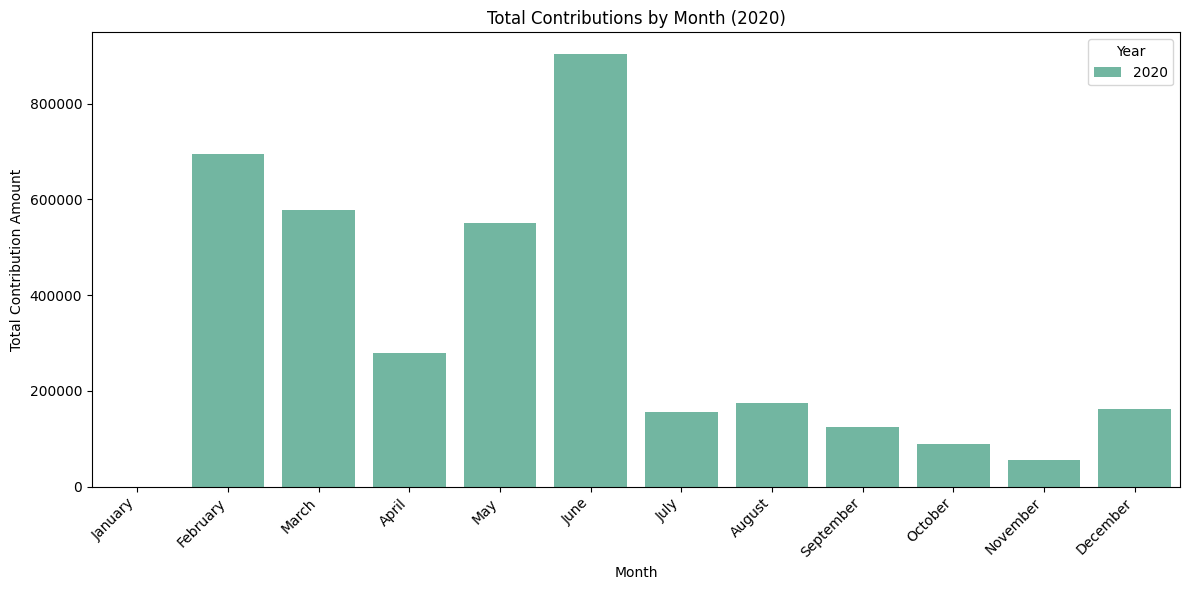

In [11]:
# Convert PeriodIndex to DataFrame and reset the index
monthly_sum_df = monthly_sum.reset_index()

# Set parameter for year
plot_year = 2020

# Convert Period to timestamp
monthly_sum_df['contrib_date'] = monthly_sum_df['contrib_date'].dt.to_timestamp()

# Extract month name and year
monthly_sum_df['month'] = monthly_sum_df['contrib_date'].dt.strftime('%B')
monthly_sum_df['year'] = monthly_sum_df['contrib_date'].dt.year

# Ensure months are in correct chronological order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_sum_df['month'] = pd.Categorical(monthly_sum_df['month'], categories=month_order, ordered=True)

# Filter for 2019 and 2020 only (if you have other years)
monthly_sum_df = monthly_sum_df[monthly_sum_df['year'].isin([plot_year])]

# Create the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_sum_df,
    x='month',
    y='contrib_amount',
    hue='year',
    palette='Set2'
)

# Beautify the plot
plt.title(f"Total Contributions by Month ({plot_year})")
plt.xlabel("Month")
plt.ylabel("Total Contribution Amount")
plt.legend(title="Year")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [12]:
# Column counts

key_column_counts = cand_contrib_df[["CID", "Party", "RecipCode", "NoPacs", "contrib_count", "State", "District"]].nunique()
print(key_column_counts)

CID               538
Party               3
RecipCode          10
NoPacs              1
contrib_count    1707
State              56
District           54
dtype: int64


In [13]:
# Top recipients

group_counts = cand_contrib_df.groupby("FirstLastP")["contrib_amount"].sum()
top_groups = group_counts.sort_values(ascending=False)
top_groups_formatted = top_groups.map(lambda x: f"${x:,.0f}")

print(top_groups_formatted)


FirstLastP
BERNIE SANDERS      $106,916,776
ELIZABETH WARREN     $64,557,578
DAVID PERDUE         $62,080,234
LINDSEY GRAHAM       $43,903,595
AMY KLOBUCHAR        $43,031,783
                        ...     
ROB WOODALL              $-4,978
PAT ROBERTS              $-7,800
DENNIS HECK             $-10,208
LAMAR ALEXANDER         $-37,900
TOM UDALL               $-89,580
Name: contrib_amount, Length: 538, dtype: object


This is where the matching file is built.

In [26]:
# Create a data frame that only has the files we need for matching
# -- Only 2020 campaign cycle (because these are the match candidates, so casting a wider net)
# -- Only house representatives, no senators

cand_contrib_df['contrib_date'] = pd.to_datetime(cand_contrib_df['contrib_date'])
cand_contrib_date_filtered_df = cand_contrib_df[(cand_contrib_df['contrib_date'] >= '2019-11-03') & (cand_contrib_df['contrib_date'] <= '2020-11-02')]
cand_contrib_district_filtered_df = cand_contrib_date_filtered_df[cand_contrib_date_filtered_df['District'] != 0]

cand_contrib_matching_df = cand_contrib_district_filtered_df[["FirstLastP", "CID", "Party", "State", "District", "Cycle"]].rename(
    columns={
        "FirstLastP": "name",
        "CID": "id",
        "Party": "match_attribute1",
        "State": "match_attribute2",
        "District": "match_attribute3",
        "Cycle": "append_attribute1",
        "": "append_attribute2",
        "": "append_attribute3"
    }
)

# Adding blank columns needed for python matching process
cand_contrib_matching_df["append_attribute2"] = ""
cand_contrib_matching_df["append_attribute3"] = ""

print(len(cand_contrib_matching_df))
cand_contrib_matching_df.head()


64503


,name,id,match_attribute1,match_attribute2,match_attribute3,append_attribute1,append_attribute2,append_attribute3
76,MO BROOKS,N00030910,R,AL,5,2020,,
77,MO BROOKS,N00030910,R,AL,5,2020,,
78,MO BROOKS,N00030910,R,AL,5,2020,,
79,MO BROOKS,N00030910,R,AL,5,2020,,
80,MO BROOKS,N00030910,R,AL,5,2020,,


In [21]:
# Output the joined cand_contrib_df to a CSV file

cand_contrib_matching_df.to_csv(
#     r"C:\Users\hefla\Documents\Work\IPS\Area 990\Data Sources\Politicking\cand_contrib_summary_2020.csv",
    "../matching/match_candidates_2020_test.csv",
    index=False,  # no row numbers
    encoding="latin1"
)

This is where the EDA of the Open Secrets FEC data starts.

In [70]:
# Create a data frame for EDA
# -- Only 2020 cycle
# -- Only house representatives, no senators

cand_contrib_df['contrib_date'] = pd.to_datetime(cand_contrib_df['contrib_date'])
cand_contrib_eda_date_filter_df = cand_contrib_df[(cand_contrib_df['contrib_date'] >= '2019-11-03') & (cand_contrib_df['contrib_date'] <= '2020-11-02')]
cand_contrib_eda_df = cand_contrib_eda_date_filter_df[cand_contrib_eda_date_filter_df['District'] != 0]

# print(len(cand_contrib_eda_df))
print(cand_contrib_eda_df.shape)
# cand_contrib_eda_df.info()
cand_contrib_eda_df.head()



(64503, 18)


,Cycle,FECCandID,CID,FirstLastP,Party Original,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,State,District,Party,contrib_date,contrib_count,contrib_amount
76,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R,2019-11-11,2,2750.0
77,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R,2019-12-23,1,2800.0
78,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R,2020-01-06,1,100.0
79,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R,2020-01-15,1,250.0
80,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R,2020-01-17,6,9000.0


C:\Users\hefla\AppData\Local\Temp\ipykernel_23244\4174048970.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


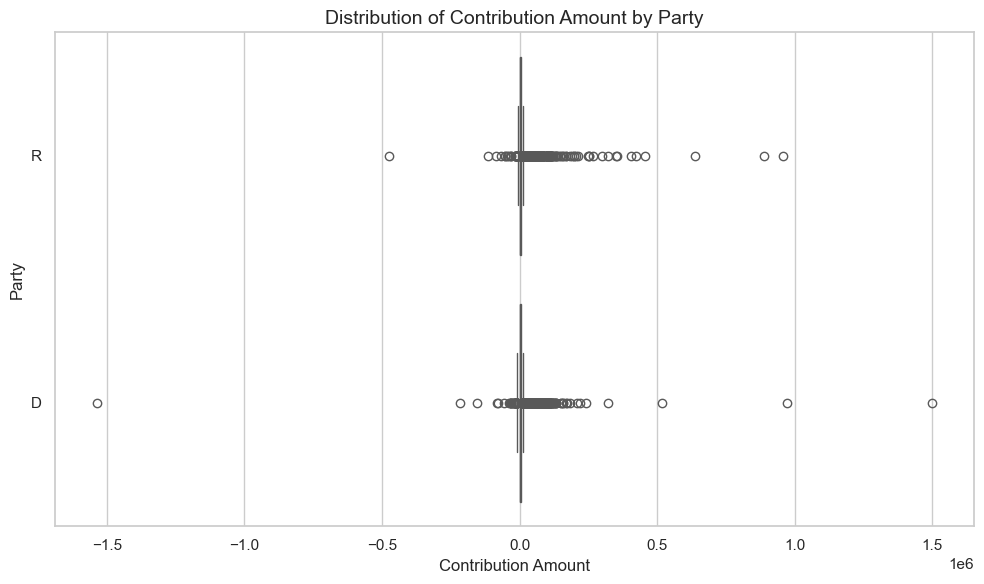

In [68]:
# Box plot of amount by party

# Filter out Party == "O"
filtered_df = cand_contrib_eda_df[cand_contrib_eda_df['Party'] != 'O'].copy()

# Set style
sns.set(style = "whitegrid")

# Create the box plot
plt.figure(figsize = (10, 6))
sns.boxplot(
    data = filtered_df,
    x='contrib_amount',
    y='Party',
    palette='Set2'
)

# Add title and labels
plt.title('Distribution of Contribution Amount by Party', fontsize=14)
plt.xlabel('Contribution Amount')
plt.ylabel('Party')

# Optional: use log scale if there are big outliers
# plt.xscale('log')

plt.tight_layout()
plt.show()

C:\Users\hefla\AppData\Local\Temp\ipykernel_23244\3397867508.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


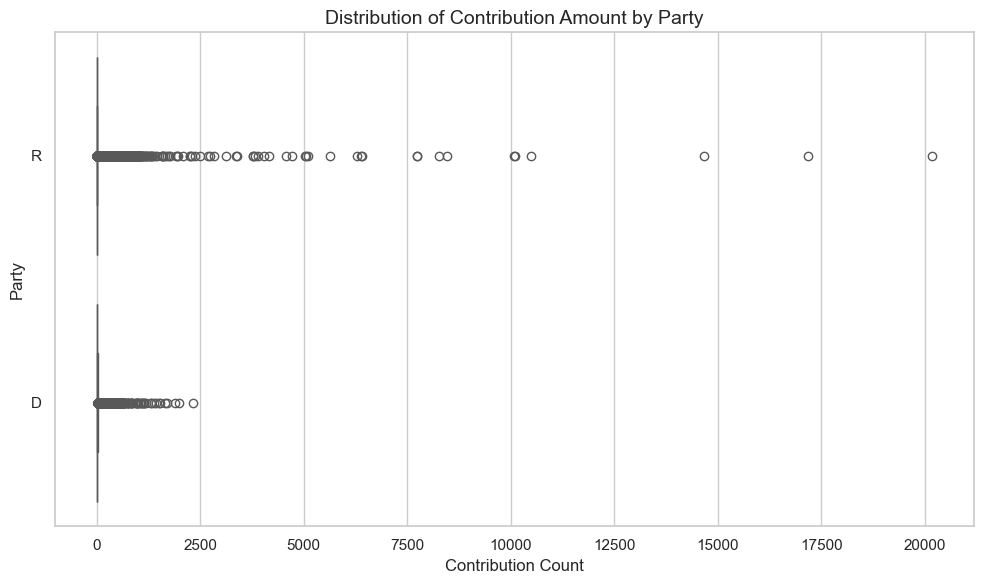

In [67]:
# Box plot of contrib count by party

# Filter out Party == "O"
filtered_df = cand_contrib_eda_df[cand_contrib_eda_df['Party'] != 'O'].copy()

# Set style
sns.set(style = "whitegrid")

# Create the box plot
plt.figure(figsize = (10, 6))
sns.boxplot(
    data = filtered_df,
    x='contrib_count',
    y='Party',
    palette='Set2'
)

# Add title and labels
plt.title('Distribution of Contribution Amount by Party', fontsize=14)
plt.xlabel('Contribution Count')
plt.ylabel('Party')

# Optional: use log scale if there are big outliers
# plt.xscale('log')

plt.tight_layout()
plt.show()

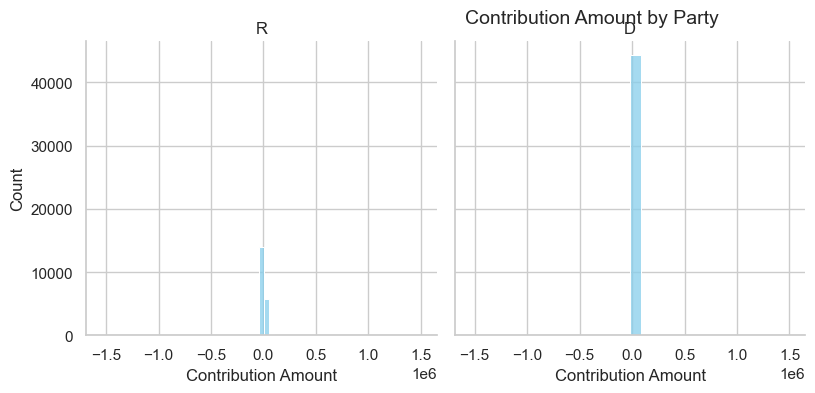

In [66]:
# Filter out Party == "O"
filtered_df = cand_contrib_eda_df[cand_contrib_eda_df['Party'] != 'O'].copy()

g = sns.FacetGrid(filtered_df, col='Party', col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, 'contrib_amount', bins=30, color='skyblue')

g.set_axis_labels('Contribution Amount', 'Count')
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Contribution Amount by Party', fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)  # make room for title
plt.show()


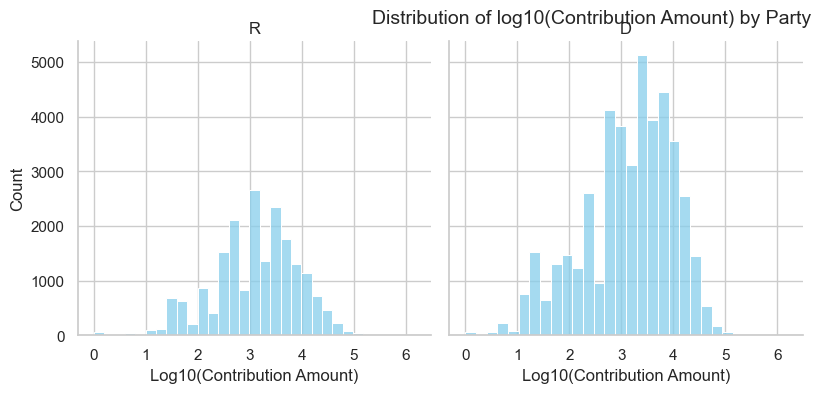

In [64]:
# Filter out Party == "O"
filtered_df = cand_contrib_eda_df[cand_contrib_eda_df['Party'] != 'O'].copy()

# Add a log-transformed column
# filtered_df['log_contrib'] = np.log10(filtered_df['contrib_amount'])
# Add a log-transformed column adding 1 to all amounts to avoid log(0)
# Remove non-positive contributions (0 or negative) to avoid log issues
filtered_df = filtered_df[filtered_df['contrib_amount'] >= 0]
filtered_df['log_contrib'] = np.log10(filtered_df['contrib_amount'] + 1)

# Faceted histograms of log(contrib_amount)
g = sns.FacetGrid(filtered_df, col='Party', col_wrap=3, height=4, sharex=True, sharey=True)
g.map(sns.histplot, 'log_contrib', bins=30, color='skyblue')

g.set_axis_labels('Log10(Contribution Amount)', 'Count')
g.set_titles(col_template='{col_name}')
g.fig.suptitle('Distribution of log10(Contribution Amount) by Party', fontsize=14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)
plt.show()


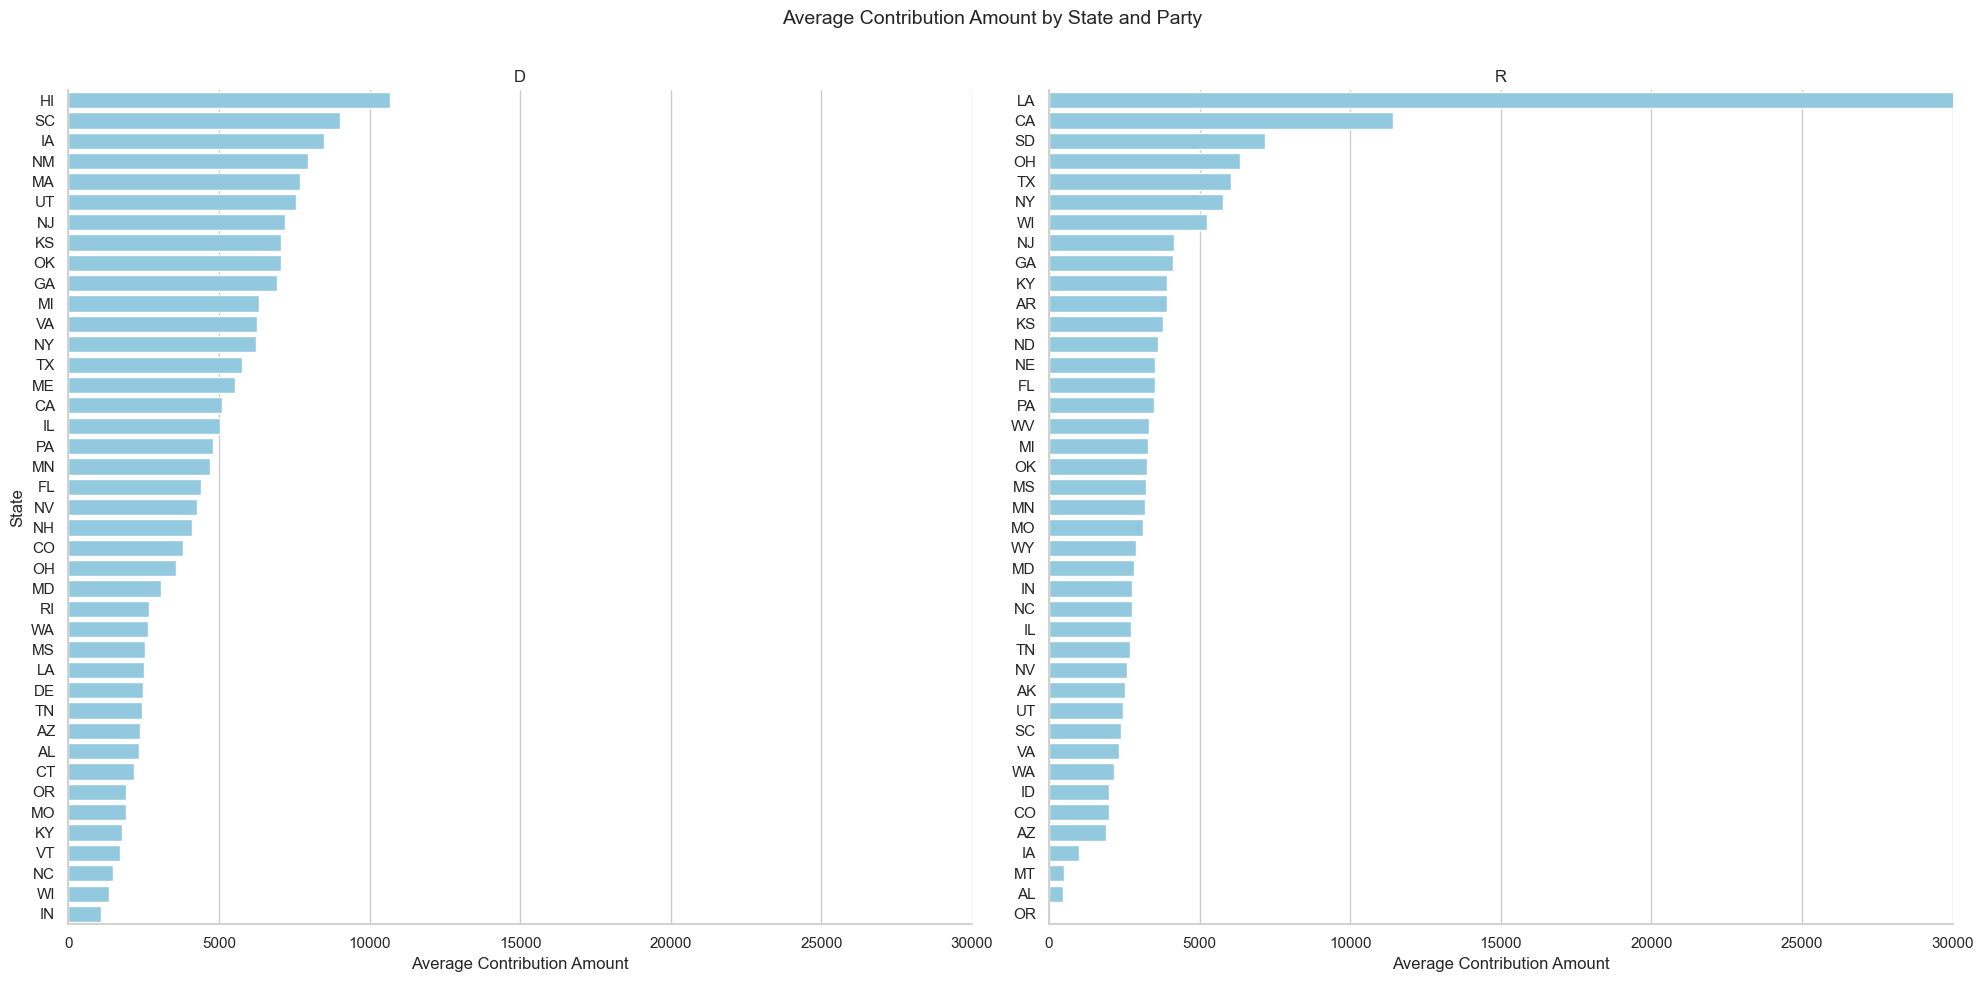

In [97]:
# 1️⃣ Compute median contribution per Party–State combo
# state_medians = (
#     cand_contrib_eda_df.groupby(['Party', 'State'], as_index=False)['contrib_amount']
#       .median()
#       .rename(columns={'contrib_amount': 'median_contrib'})
# )

# Compute average contribution per Party–State combo
state_averages = (
    cand_contrib_eda_df.groupby(['Party', 'State'], as_index=False)['contrib_amount']
      .mean()
      .rename(columns={'contrib_amount': 'average_contrib'})
)

# 2️⃣ Filter to only D and R
state_averages = state_averages[state_averages['Party'].isin(['D', 'R'])]

# 3️⃣ Sort within each Party
state_averages = state_averages.sort_values(['Party', 'average_contrib'], ascending=[True, False])

# 4️⃣ Create faceted horizontal bar charts
g = sns.FacetGrid(
    state_averages,
    col = 'Party',
    sharex = True, 
    sharey = False, 
    height = 10,
    col_order=['D', 'R']
)

# Custom plotting function to sort states by average_contrib in each facet
def facet_barplot(data, color):
    sns.barplot(
        data=data,
        y='State',
        x='average_contrib',
        color=color,
        order=data.sort_values('average_contrib', ascending=False)['State']
    )

# Map barplot to each facet
g.map_dataframe(facet_barplot, color='skyblue')

# 5️⃣ Adjust labels, limits, and layout
g.set_axis_labels('Average Contribution Amount', 'State')
g.set_titles(col_template='{col_name}')
g.set(xlim=(0, 30000))  # consistent x-axis range
g.fig.suptitle('Average Contribution Amount by State and Party', fontsize = 14)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

plt.show()



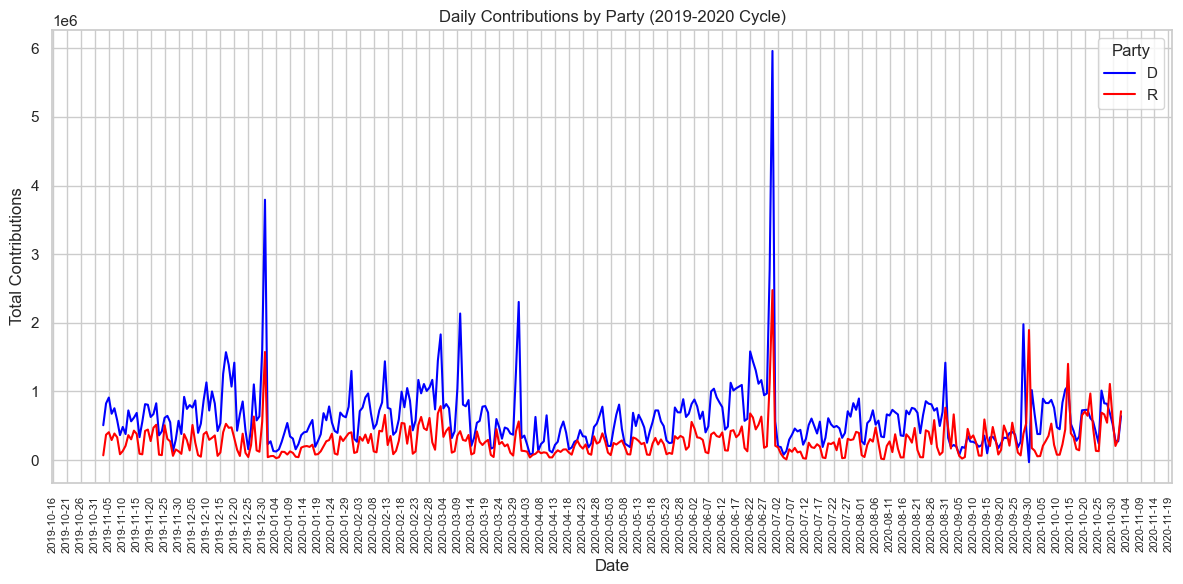

In [77]:
# 1️⃣ Filter to only D and R
time_df = cand_contrib_eda_df[cand_contrib_eda_df['Party'].isin(['D', 'R'])].copy()

# 2️⃣ Aggregate contributions by date and party
daily_contrib = (
    time_df.groupby(['contrib_date', 'Party'], as_index=False)['contrib_amount']
    .sum()  # sum contributions per day
)

# 3️⃣ Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_contrib,
    x='contrib_date',
    y='contrib_amount',
    hue='Party',
    palette={'D': 'blue', 'R': 'red'}
)

# 4️⃣ Add labels, title, and formatting
plt.xlabel('Date')
plt.ylabel('Total Contributions')
plt.title('Daily Contributions by Party (2019-2020 Cycle)')

# Set x-axis major ticks every 5 days
ax = plt.gca()  # get current axes
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation = 90, fontsize = 8)  # rotate x-axis for readability
plt.tight_layout()
plt.show()

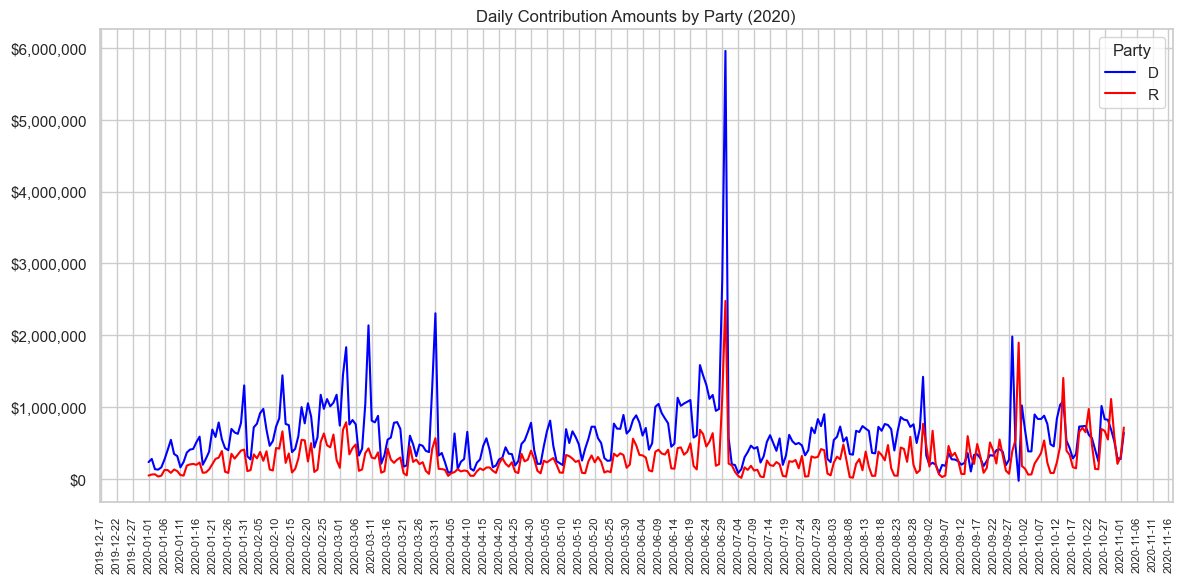

In [85]:
# Filter on specific date range
date_df = cand_contrib_eda_df[(cand_contrib_eda_df['contrib_date'] >= '2020-01-01') & (cand_contrib_eda_df['contrib_date'] <= '2020-11-02')]

# 1️⃣ Filter to only D and R
time_df = date_df[date_df['Party'].isin(['D', 'R'])].copy()

# 2️⃣ Aggregate contributions by date and party
daily_contrib = (
    time_df.groupby(['contrib_date', 'Party'], as_index=False)['contrib_amount']
    .sum()  # sum contributions per day
)

# 3️⃣ Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_contrib,
    x='contrib_date',
    y='contrib_amount',
    hue='Party',
    palette={'D': 'blue', 'R': 'red'}
)

# 4️⃣ Add labels, title, and formatting
plt.xlabel('')
plt.ylabel('')
plt.title('Daily Contribution Amounts by Party (2020)')

ax = plt.gca()  # get current axes
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# Set x-axis major ticks every 5 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation = 90, fontsize = 8)  # rotate x-axis for readability
plt.tight_layout()
plt.show()

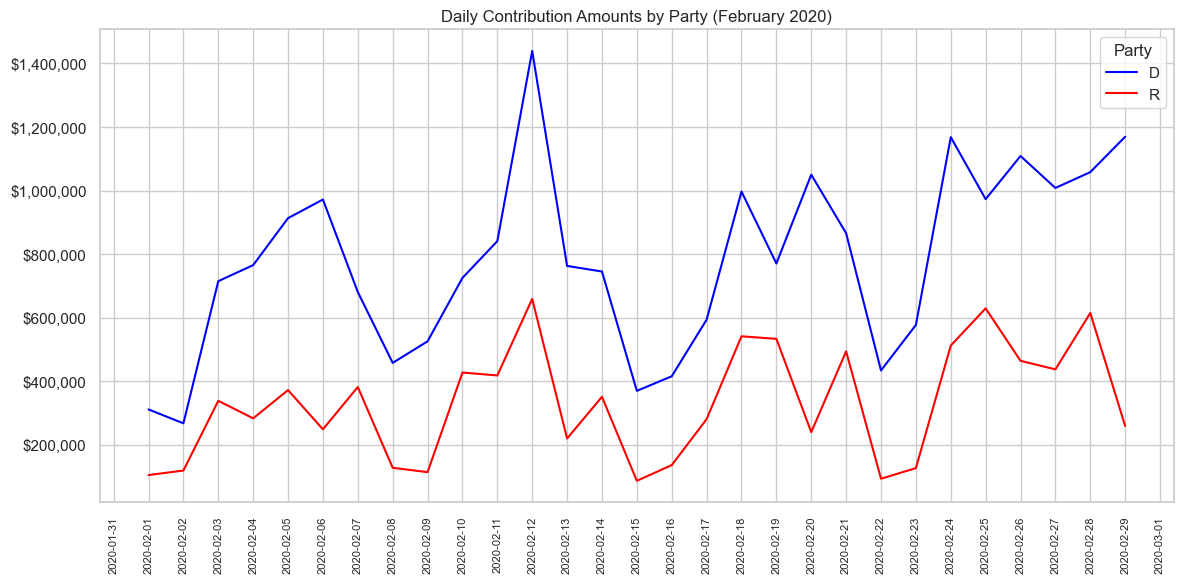

In [ ]:
# Filter on specific date range
date_df = cand_contrib_eda_df[(cand_contrib_eda_df['contrib_date'] >= '2020-02-01') & (cand_contrib_eda_df['contrib_date'] <= '2020-02-29')]

# 1️⃣ Filter to only D and R
time_df = date_df[date_df['Party'].isin(['D', 'R'])].copy()

# 2️⃣ Aggregate contributions by date and party
daily_contrib = (
    time_df.groupby(['contrib_date', 'Party'], as_index=False)['contrib_amount']
    .sum()  # sum contributions per day
)

# 3️⃣ Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_contrib,
    x='contrib_date',
    y='contrib_amount',
    hue='Party',
    palette={'D': 'blue', 'R': 'red'}
)

# 4️⃣ Add labels, title, and formatting
plt.xlabel('')
plt.ylabel('')
plt.title('Daily Contribution Amounts by Party (February 2020)')

ax = plt.gca()  # get current axesA
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# Set x-axis major ticks every 5 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation = 90, fontsize = 8)  # rotate x-axis for readability
plt.tight_layout()
plt.show()

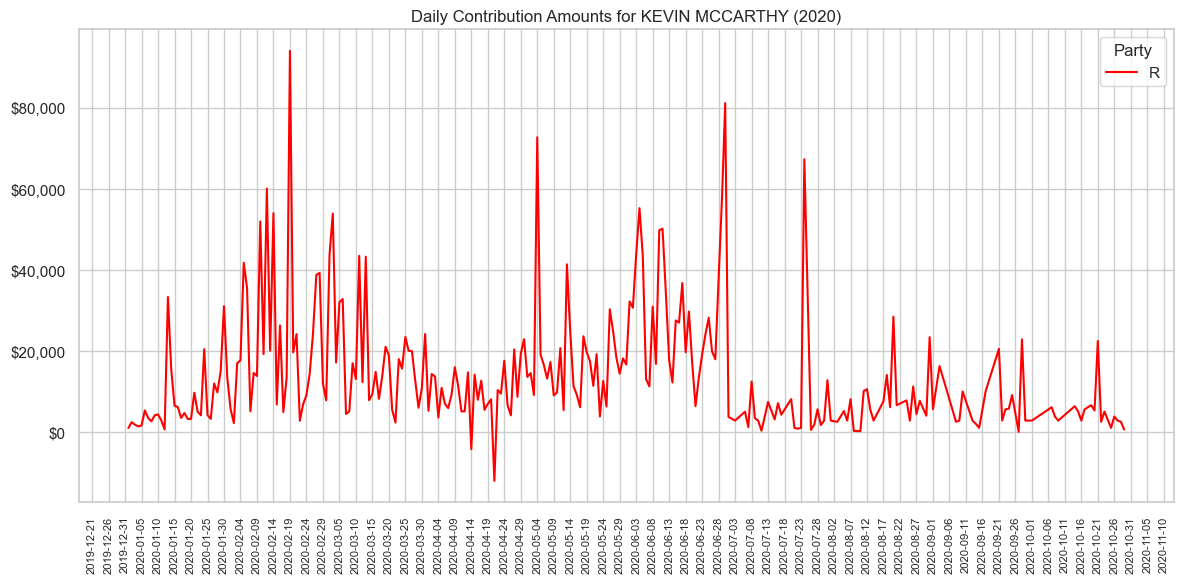

In [92]:
# Filter only on specific politician
politician = "KEVIN MCCARTHY"
pol_df = cand_contrib_eda_df[(cand_contrib_eda_df['FirstLastP'].str.contains("MCCARTHY"))]

# Filter on specific date range
date_df = pol_df[(pol_df['contrib_date'] >= '2020-01-01') & (pol_df['contrib_date'] <= '2020-11-02')]

# 1️⃣ Filter to only D and R
time_df = date_df[date_df['Party'].isin(['D', 'R'])].copy()

# 2️⃣ Aggregate contributions by date and party
daily_contrib = (
    time_df.groupby(['contrib_date', 'Party'], as_index=False)['contrib_amount']
    .sum()  # sum contributions per day
)

# 3️⃣ Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=daily_contrib,
    x='contrib_date',
    y='contrib_amount',
    hue='Party',
    palette={'D': 'blue', 'R': 'red'}
)

# 4️⃣ Add labels, title, and formatting
plt.xlabel('')
plt.ylabel('')
plt.title(f'Daily Contribution Amounts for {politician} (2020)')

ax = plt.gca()  # get current axesA
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# Set x-axis major ticks every 5 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation = 90, fontsize = 8)  # rotate x-axis for readability
plt.tight_layout()
plt.show()

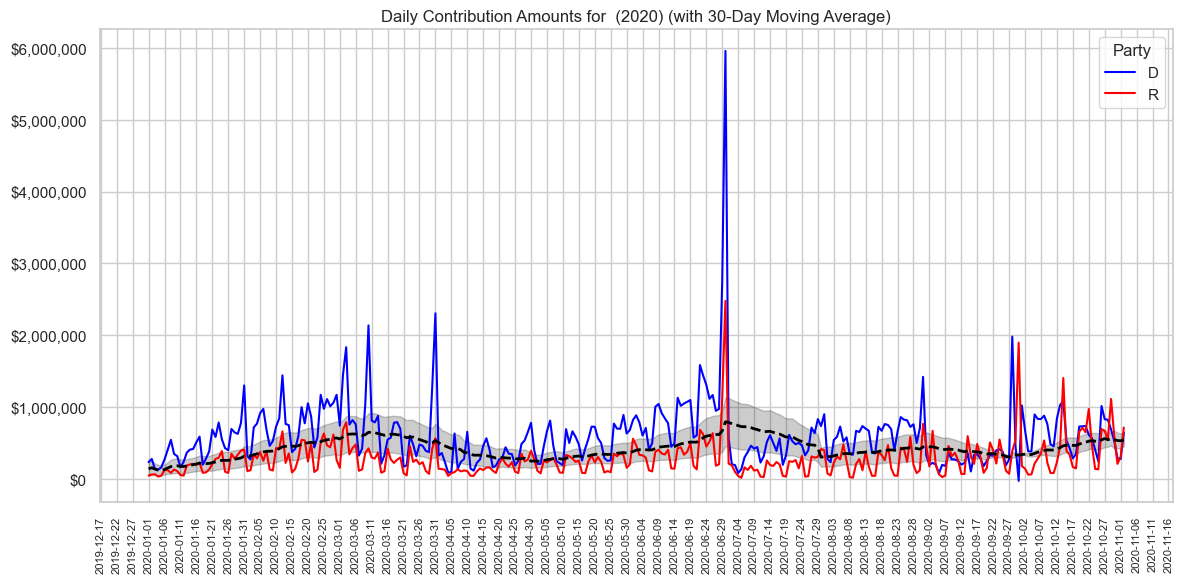

In [108]:
# Set filters
politician = ""
moving_avg = 30

# Filter only on specific politician
pol_df = cand_contrib_eda_df[cand_contrib_eda_df['FirstLastP'].str.contains(politician)]

# Filter on specific date range
date_df = pol_df[(pol_df['contrib_date'] >= '2020-01-01') & (pol_df['contrib_date'] <= '2020-11-02')]

# 1️⃣ Filter to only D and R
time_df = date_df[date_df['Party'].isin(['D', 'R'])].copy()

# 2️⃣ Aggregate contributions by date and party
daily_contrib = (
    time_df.groupby(['contrib_date', 'Party'], as_index=False)['contrib_amount']
    .sum()
)

# 3️⃣ Calculate rolling average per Party
daily_contrib['rolling_avg'] = (
    daily_contrib
    .sort_values(['Party', 'contrib_date'])
    .groupby('Party')['contrib_amount']
    .transform(lambda x: x.rolling(moving_avg, min_periods=1).mean())
)

# 4️⃣ Plot
plt.figure(figsize=(12, 6))

# Daily contributions
sns.lineplot(
    data=daily_contrib,
    x='contrib_date',
    y='contrib_amount',
    hue='Party',
    palette={'D': 'blue', 'R': 'red'},
    linewidth=1.5
)

# Rolling average (black dashed line)
sns.lineplot(
    data=daily_contrib,
    x='contrib_date',
    y='rolling_avg',
    color='black',
    linestyle='--',
    linewidth=2,
    legend=False  # disable legend duplication
)

# Labels and title
plt.xlabel('')
plt.ylabel('')
plt.title(f'Daily Contribution Amounts for {politician} (2020) (with {moving_avg}-Day Moving Average)')

# Format y-axis as currency
ax = plt.gca()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

# Set x-axis ticks every 5 days
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()